# Let's figure out these freaking learning rates

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
from src.clr import LRFinder
import matplotlib.ticker as ticker

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(1)
limit_mem()

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [142]:
class RunLRFind():
    def __init__(self, exp_id, train_years=['2014', '2015'],
                 ext_exp_id='81-resnet_d3_dr_0.1'):
        self.train_years = train_years
        self.args = load_args(f'../nn_configs/B/{exp_id}.yml')
        self.ext_exp_id = ext_exp_id
        self.load_data()
        self.build_model()
        
        
    def build_model(self):
        args = self.args
        dg_train = self.dg_train
        if args['network_type'] == 'resnet':
            model = build_resnet(
                **args, input_shape=dg_train.shape,
            )
        elif args['network_type'] == 'uresnet':
            model = build_uresnet(
                **args, input_shape=dg_train.shape,
            )
        if args['loss'] == 'lat_mse':
            loss = create_lat_mse(dg_train.data.lat)
        if args['loss'] == 'lat_rmse':
            loss = create_lat_rmse(dg_train.data.lat)
        if args['optimizer'] == 'adam':
            opt = keras.optimizers.Adam(args['lr'])
        elif args['optimizer'] =='adadelta':
            opt = keras.optimizers.Adadelta(args['lr'])
        elif args['optimizer'] =='sgd':
            opt = keras.optimizers.SGD(args['lr'], momentum=args['momentum'], nesterov=True)
        model.compile(opt, loss, metrics=['mse'])
        self.model = model
        
    def load_data(self):
        if self.ext_exp_id is None:
            self.args['train_years'] = self.train_years
            dg_train, dg_valid, dg_test = load_data(**self.args)
            self.dg_train, self.dg_valid = dg_train, dg_test
        else:
            mean = xr.open_dataarray(f"{self.args['model_save_dir']}/{self.ext_exp_id}_mean.nc")
            std = xr.open_dataarray(f"{self.args['model_save_dir']}/{self.ext_exp_id}_std.nc")
            self.args['ext_mean'] = mean
            self.args['ext_std'] = std
            dg_test = load_data(**self.args, only_test=True)
            self.dg_train = dg_test
        
    def find_lr(self, minimum_lr=1e-6, maximum_lr=1e-3, lr_scale='exp'):
        self.lrf = LRFinder(
            self.dg_train.n_samples, self.dg_train.batch_size,
            minimum_lr=minimum_lr, maximum_lr=maximum_lr,
            lr_scale=lr_scale, save_dir='./', verbose=0, 
            validation_data=self.dg_valid if self.ext_exp_id is None else None,
            stopping_criterion_factor=100
        )
        self.model.fit(self.dg_train, epochs=1, callbacks=[self.lrf])
        return self.lrf
        
    def plot(self, xlim=None, ylim=None, log=False):
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.plot(10**self.lrf.lrs, self.lrf.losses)
        plt.xlabel('lr'); plt.ylabel('loss')
        if log: plt.yscale('log')
        if ylim is not None: plt.ylim(ylim)
        if xlim is not None: plt.xlim(xlim)
        x_labels = ax.get_xticks()
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        
def plot_lrfs(lrfs, xlim=None, ylim=None, log=False, labels=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    for i, lrf in enumerate(lrfs): 
        lrs = lrf.lrs
        if lrf.lr_scale == 'exp': lrs = 10** lrs
        ax.plot(lrs, lrf.losses, label=labels[i] if not labels is None else None)
    plt.xlabel('lr'); plt.ylabel('loss')
    if log: plt.yscale('log')
    if ylim is not None: plt.ylim(ylim)
    if xlim is not None: plt.xlim(xlim)
    x_labels = ax.get_xticks()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
    if labels is not None: plt.legend()

In [145]:
lrf = RunLRFind('81-resnet_d3_dr_0.1')

In [152]:
lrfs = []
lrf.build_model()
lrfs.append(lrf.find_lr(lr_scale='exp', minimum_lr=1e-5, maximum_lr=1e-1))

  ...
    to  
  ['...']
Train for 273 steps
273/273 [==============================] - 59s 216ms/step - loss: nan - mse: nan


In [154]:
lrf.args['l2']

1e-05

In [155]:
lrf.args['optimizer'] = 'sgd'
lrf.build_model()
lrfs.append(lrf.find_lr(lr_scale='exp', minimum_lr=1e-5, maximum_lr=1e-1))

  ...
    to  
  ['...']
Train for 273 steps
273/273 [==============================] - 59s 216ms/step - loss: nan - mse: nan


In [160]:
lrf.args['optimizer'] = 'sgd'
lrf.args['momentum'] = 0.99
lrf.build_model()
lrfs.append(lrf.find_lr(lr_scale='exp', minimum_lr=1e-5, maximum_lr=1e-1))

  ...
    to  
  ['...']
Train for 273 steps
273/273 [==============================] - 59s 214ms/step - loss: inf - mse: inf


In [ ]:
kera

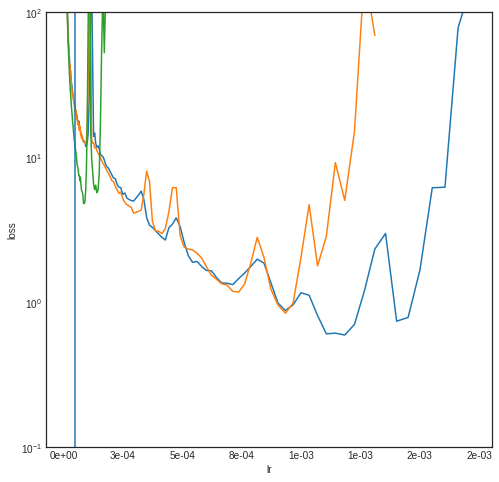

In [161]:
plot_lrfs(lrfs, log=True, ylim=(1e-1, 100))
plt.axvline(5e-5)

In [116]:
lrf.dg_train.batch_size = 64
lrf.build_model()
lrfs.append(lrf.find_lr(lr_scale='exp', minimum_lr=1e-5, maximum_lr=1))

  ...
    to  
  ['...']
Train for 137 steps
137/137 [==============================] - 58s 426ms/step - loss: 2441.4238 - mse: 2265.6465


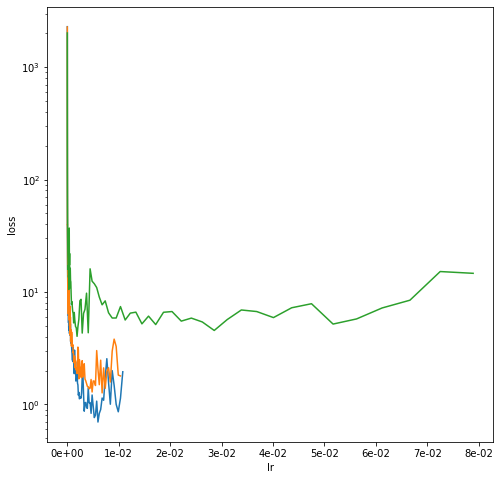

In [118]:
plot_lrfs(lrfs, log=True)